In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split,DataLoader,TensorDataset
import numpy as np

Data

In [ ]:
#link to download the data
url1='https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
url2='https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data'
url3='https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data'
url4='https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data'
#handle data
data_cleveland = pd.read_csv(url1,sep=',',header=None)
data_hungarian = pd.read_csv(url2,sep=',',header=None)
data_swiss = pd.read_csv(url3,sep=',',header=None)
data_va = pd.read_csv(url4,sep=',',header=None)
data_cleveland.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']
data_hungarian.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']
data_swiss.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']
data_va.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']
data_cleveland = data_cleveland.replace('?',np.nan).dropna()
data_hungarian = data_hungarian.replace('?',np.nan).dropna()
data_swiss = data_swiss.replace('?',np.nan).dropna()
data_va = data_va.replace('?',np.nan).dropna()


In [ ]:
#merge the remaining data. However, only majority of cleveland data is left.
frames = [data_cleveland,data_hungarian,data_swiss,data_va]
data = pd.concat(frames)


#normalize the input features that do not have the range between one and zero
col2zscore = data_cleveland.keys()
col2zscore = col2zscore.drop(['sex','fbs','exang','DISEASE'])



#normalize the input features from data
for col in col2zscore:
    d=pd.to_numeric(data[col])
    data[col] = (d-d.mean())/d.std(ddof=1)


#get data and label, data is between column 0-12 and the label is column 13
heart_data = data.iloc[:,0:13].values
heart_label=data.iloc[:,13].values

#since heart_data is numpy object, which can not change to tensor. Therefore, we need to change from object to array of float. This problem normally happes when we read data from data frame using pandas

heart_data = np.vstack(heart_data[:,:]).astype(np.float64)

heart_data = torch.tensor(heart_data).float()
heart_label = torch.tensor(heart_label).float()

Load Dataset

In [ ]:
heart_dataset = TensorDataset(heart_data,heart_label)

train_dataset,test_dataset = random_split(heart_dataset,[240,59])

batch_size=20
train_loader = DataLoader(train_dataset,batch_size=batch_size,drop_last=True,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=int(len(test_dataset)))


Building NN

In [ ]:
def create_model(nUnits, nLayers):
    class HeartDiseaseModel(nn.Module):
        def __init__(self, nUnits, nLayers):
            super().__init__()
            self.fc1 = nn.ModuleList()
            self.fc1.append(nn.Linear(13, 500)) # increase the number of units in the first layer to 500
            self.bn11 = nn.BatchNorm1d(500) # add batch normalization after the first layer
            self.fc1.append(nn.Linear(500, nUnits))
            self.bn12 = nn.BatchNorm1d(nUnits) # add batch normalization after the second layer
            self.dropout = nn.Dropout(0.5)
            for i in range(nLayers - 1):
                self.fc1.append(nn.Linear(nUnits, nUnits))
            self.output_layer = nn.Linear(nUnits, 1)

        def forward(self, x):
            for layer in self.fc1:
                x = F.relu(layer(x))
                x = self.dropout(x)
            x = self.output_layer(x)
            return x

    net = HeartDiseaseModel(nUnits, nLayers)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    return net, criterion, optimizer











Train Network

In [ ]:
def function2trainmodel(nUnits,nLayers, train_loader, test_loader):
    training_epoch = 500
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net, loss_fn, optimizer = create_model(nUnits,nLayers)
    net.to(device) # move the model to the GPU device (if available)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5) # add a learning rate scheduler
    trainLoss = torch.zeros(training_epoch)
    testLoss = torch.zeros(training_epoch)
    trainAcc = torch.zeros(training_epoch)
    testAcc = torch.zeros(training_epoch)

    for epoch in range(training_epoch):
        # loop over training data batches
        batchLoss = []
        for X, y in train_loader:
            # forward pass and loss
            output_y = net(X)
            y = y.unsqueeze(1)
            loss = loss_fn(output_y,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # train accuracy
            predictions = (torch.sigmoid(output_y)>.5).float()
            trainAcc[epoch] = 100*torch.mean((predictions==y).float())

        # end of batch loop...

        # get average losses across the batches
        trainLoss[epoch] = np.mean(batchLoss)

        ## now for the test
        X, y = next(iter(test_loader))
        output_y = net(X)
        y = y.unsqueeze(1)

        # test loss
        loss = loss_fn(output_y, y)
        testLoss[epoch] = loss.item()

        # test accuracy
        predictions = (torch.sigmoid(output_y)>.5).float()
        testAcc[epoch] = 100*torch.mean((predictions==y).float())

        # Update the learning rate
        #scheduler.step(testLoss[epoch])

    return net, trainAcc, testAcc, loss, trainLoss, testLoss


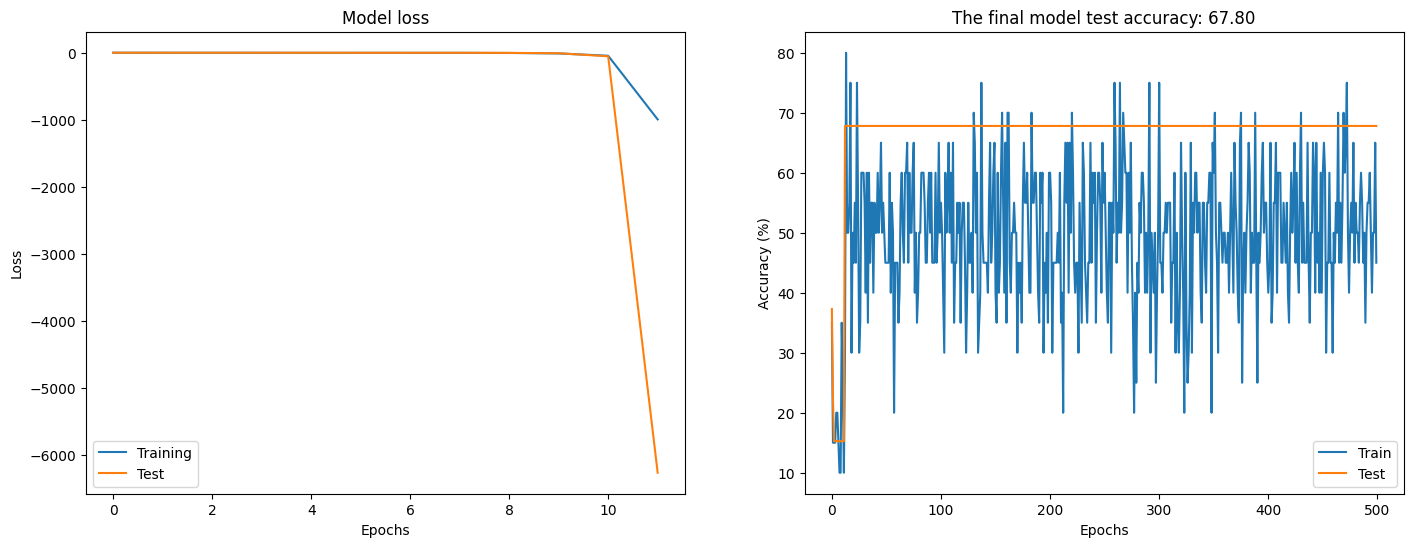

In [ ]:
nnet, trainAcc, testAcc, loss, trainLoss, testLoss = function2trainmodel(64, 2,train_loader,test_loader)

fig, ax = plt.subplots(1, 2, figsize=(17, 6))

ax[0].plot(trainLoss, label='Training')
ax[0].plot(testLoss, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'The final model test accuracy: {testAcc[-1]:.2f}')
ax[1].legend()

plt.show()